In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage
from cv2 import COLOR_BGR2GRAY, cvtColor, imread, imshow, waitKey
from numpy import dot, exp, mgrid, pi, ravel, square, uint8, zeros
import cv2
from itertools import product

In [69]:
img = imread(r"../data/84x84.jpg")

In [70]:

def gen_gaussian_kernel(k_size, sigma):
    center = k_size // 2
    x, y = mgrid[0 - center : k_size - center, 0 - center : k_size - center]
    g = 1 / (2 * pi * sigma) * exp(-(square(x) + square(y)) / (2 * square(sigma)))
    return g


def gaussian_filter(image, k_size, sigma):
    height, width = image.shape[0], image.shape[1]

    dst_height = height - k_size + 1
    dst_width = width - k_size + 1


    image_array = zeros((dst_height * dst_width, k_size * k_size))

    row = 0
    for i, j in product(range(dst_height), range(dst_width)):
        window = ravel(image[i : i + k_size, j : j + k_size])
        image_array[row, :] = window

        row += 1


    gaussian_kernel = gen_gaussian_kernel(k_size, sigma)
    filter_array = ravel(gaussian_kernel)


    dst = dot(image_array, filter_array).reshape(dst_height, dst_width).astype(uint8)

    return dst


C:\Users\Admin\AppData\Local\Temp\ipykernel_10116\3710297049.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_img = imageio.imread(r"../data/aaa.jpg")


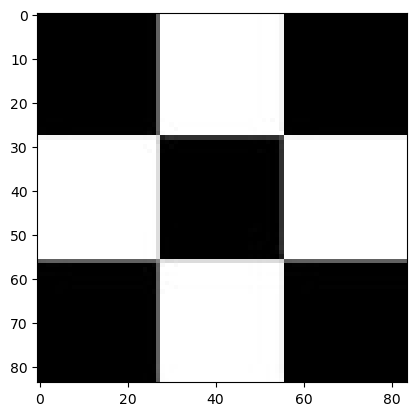

In [71]:
input_img = imageio.imread(r"../data/aaa.jpg")
plt.imshow(img[:,:,::-1])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


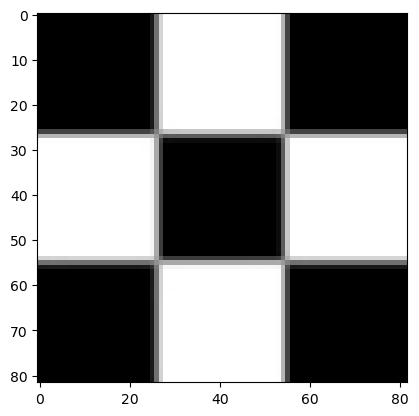

In [73]:
img = img[:,:,0]
print(gaussian_filter(img,3,1))
dst = gaussian_filter(img,3,1)
resz = cv2.resize(dst,(400,400))
plt.imshow(gaussian_filter(img,3,1),cmap="gray")

(Text(0.5, 1.0, 'Sobel Y'), ([], []), ([], []))

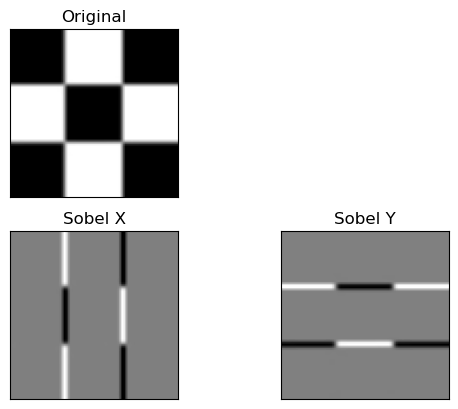

In [74]:
# convolute with proper kernels
sobelx = cv2.Sobel(dst,cv2.CV_64F,1,0,ksize=3)  # x
sobely = cv2.Sobel(dst,cv2.CV_64F,0,1,ksize=3)  # y

plt.subplot(2,2,1),plt.imshow(dst,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])


(Text(0.5, 1.0, 'grad_dir'), ([], []), ([], []))

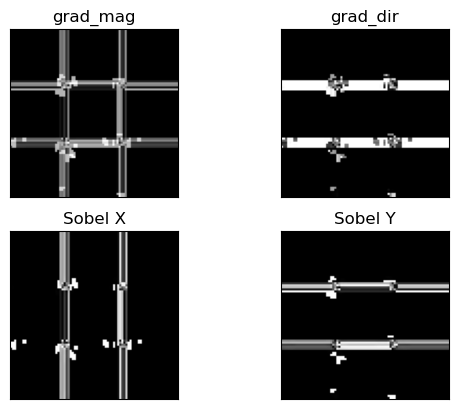

In [76]:
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))
    return grad_img/np.max(grad_img)

def gradient_mag(fx, fy) :
    grad_mag = np.hypot(fx, fy)
    return grad_mag/np.max(grad_mag)

xsobel = gradient_x(dst)
ysobel = gradient_y(dst)
grad_mag = gradient_mag(xsobel,ysobel)
grad_dir = np.degrees(np.arctan2(ysobel, xsobel))

plt.subplot(2,2,3),plt.imshow(xsobel,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(ysobel,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,1),plt.imshow(grad_mag,cmap = 'gray')
plt.title('grad_mag'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(grad_dir,cmap = 'gray')
plt.title('grad_dir'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'closest_dir'), ([], []), ([], []))

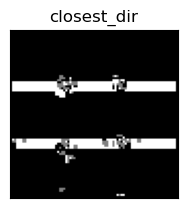

In [77]:
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
                
    return closest_dir_arr
closest_dir = closest_dir_function(grad_dir)
plt.subplot(2,2,1),plt.imshow(closest_dir,cmap = 'gray')
plt.title('closest_dir'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'thinned_output'), ([], []), ([], []))

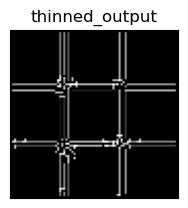

In [78]:
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output)   
thinned_output = non_maximal_suppressor(grad_mag, closest_dir)
plt.subplot(2,2,1),plt.imshow(thinned_output,cmap = 'gray')
plt.title('thinned_output'), plt.xticks([]), plt.yticks([])

(Text(0.5, 1.0, 'output_img'), ([], []), ([], []))

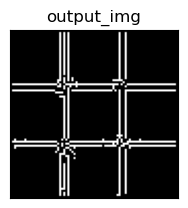

In [79]:
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    
output_img = hysteresis_thresholding(thinned_output)
plt.subplot(2,2,1),plt.imshow(output_img,cmap = 'gray')
plt.title('output_img'), plt.xticks([]), plt.yticks([])